<a href="https://colab.research.google.com/github/blakesodikoff/1221DarkMatter/blob/main/sodikoff_Exoplanet_Transit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # import numpy library
import matplotlib.pyplot as plt # import pyplot
import astropy.io.ascii # imoprt ascii to read files

In [ ]:
from google.colab import files # import file
uploaded = files.upload() # open file

Saving HD209458b (2).txt to HD209458b (2).txt


In [ ]:
# http://var2.astro.cz/EN/tresca/transit-detail.php?id=1535045428
dat = astropy.io.ascii.read("HD209458b (2).txt") # read file

Text(0, 0.5, 'Normalize Flux')

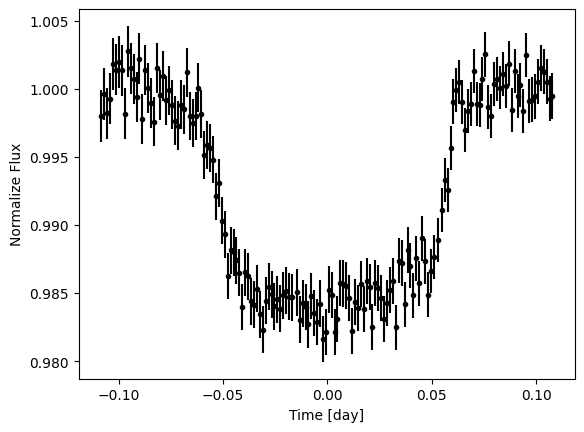

In [ ]:
# subtract median of column 1 from each value
time = dat["col1"] - np.median(dat["col1"])
# Assign values of column 2 to rel_mag
rel_mag = dat["col2"]
# convert relative magnitude to flux
flux = 2.514**(1.0 - rel_mag)
# Assign values of column 3 to err
err = dat["col3"]
# plot flux with error bars
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none")
# plot labels for x and y axes.
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")

In [ ]:
# define box model as a function to create a box model of the curve using given parameters
def box_model(t, center_time, duration, depth, delta_flux):
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0))
  f[ind] = 1.0 + delta_flux
  return(f)

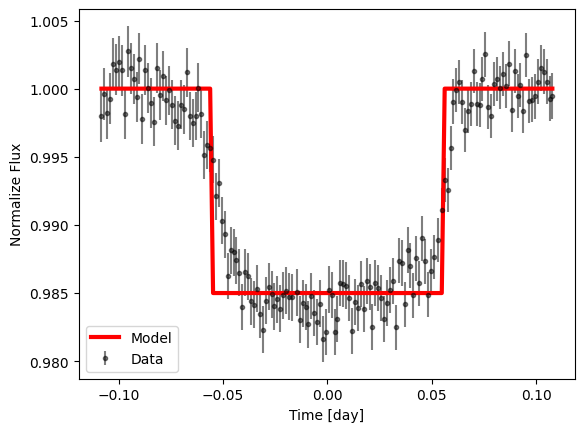

In [ ]:
# initializes parameters for the transit model, and plots
center_time, duration, depth, delta_flux = 0.0, 0.11, 0.015, 0.0
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [ ]:
# define a function to calculate reduced chi square to measure goodness of fit.
def calc_reduced_Chi2(O, C, err, n, m):
  Chi2 = np.sum((O - C)**2 / err**2)
  reduced_Chi2 = Chi2 / (n - m)
  return(reduced_Chi2)

In [ ]:
# prints reduced chi square value
print("reduced Chi2 = ", calc_reduced_Chi2(flux, model, err, len(time), 4.0))


reduced Chi2 =  1.9189961992668991


In [ ]:
#define log likeihood to calculate log of the likelihood of the model with given data.
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux = theta
    model = box_model(time, center_time, duration, depth, delta_flux)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [ ]:
# Define log prior to compute log of prior probabilities of the given parameters.
def log_prior(theta):
    center_time, duration, depth, delta_flux = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 and -0.1 < delta_flux < 0.1:
        return 0.0
    return -np.inf
# define log probability by combining prior and likelihood
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [ ]:
# install emcee package
! pip install -U emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.0 MB/s eta 0:00:00


In [ ]:
# import emcee package
import emcee

pos = np.array([0.0, 0.1, 0.02, 0.0]) + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape
# creates enablesampler object
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 10000, progress=True);


100%|██████████| 10000/10000 [02:07<00:00, 78.42it/s]


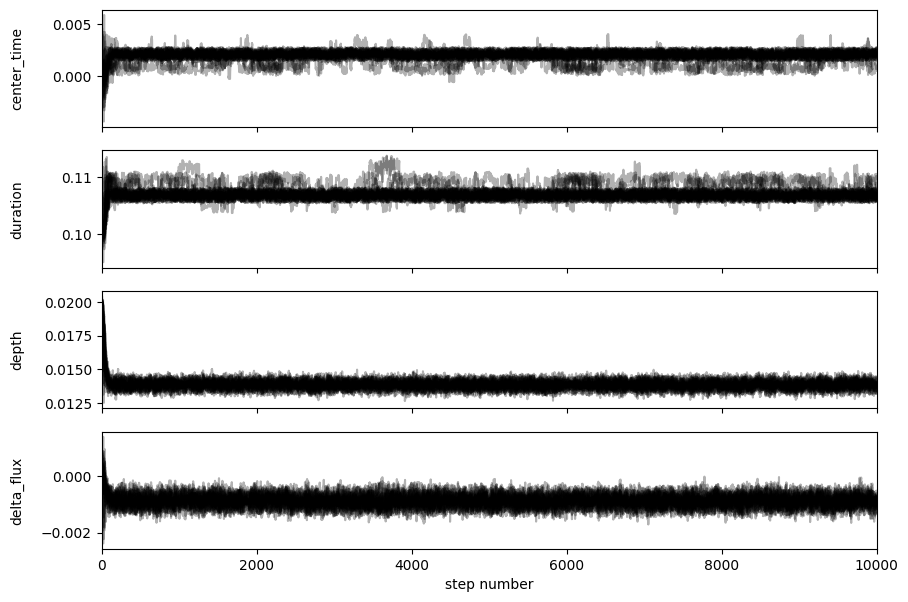

In [ ]:
# create subplots for each parameter in the model
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux"]
# find and plot each parameter showing evolution through time
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# flatten the array of samples after discarding steps to thin the chain.
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

(6336, 4)


In [ ]:
# install corner package
! pip install corner


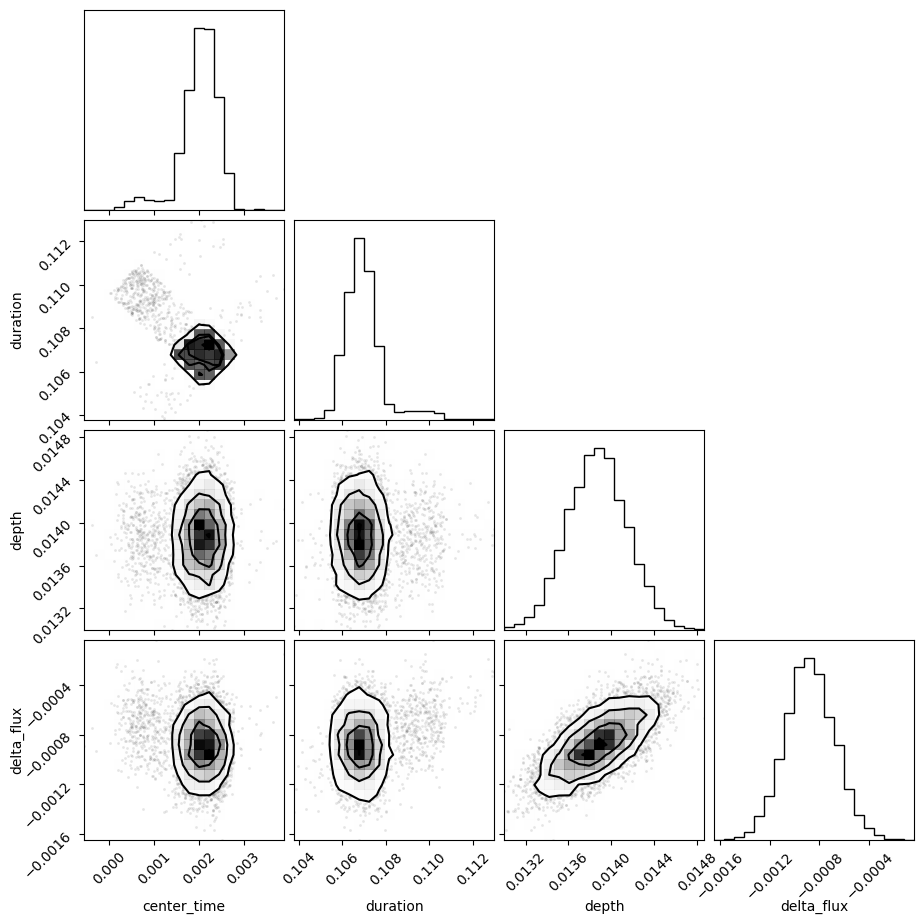

In [ ]:
# import the corner module to create a corner plot of the samples
import corner
fig = corner.corner(flat_samples, labels=labels);

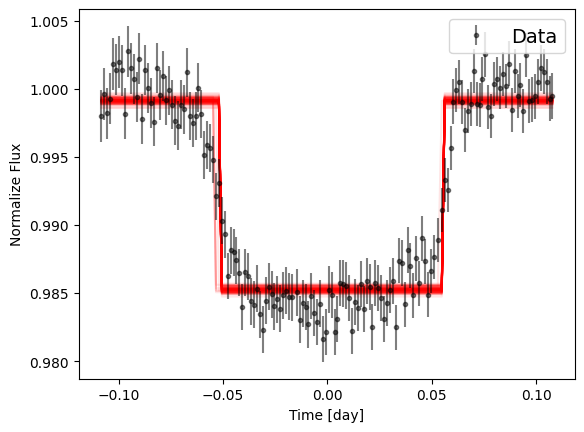

In [ ]:
# randomly select set of parameter samples from the results
inds = np.random.randint(len(flat_samples), size=100)
# for each sample, plot corresponding model.
for ind in inds:
    sample = flat_samples[ind]
    center_time, duration, depth, delta_flux = sample
    plt.plot(time, box_model(time, center_time, duration, depth, delta_flux), color="red", alpha=0.1)
# plot original data for comparison.
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.legend(fontsize=14)
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux");


In [ ]:
# import display and math package
from IPython.display import display, Math
# calculate 16 50 and 84 percentile of the sample for each parameter.
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
# display parameter in clear format
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

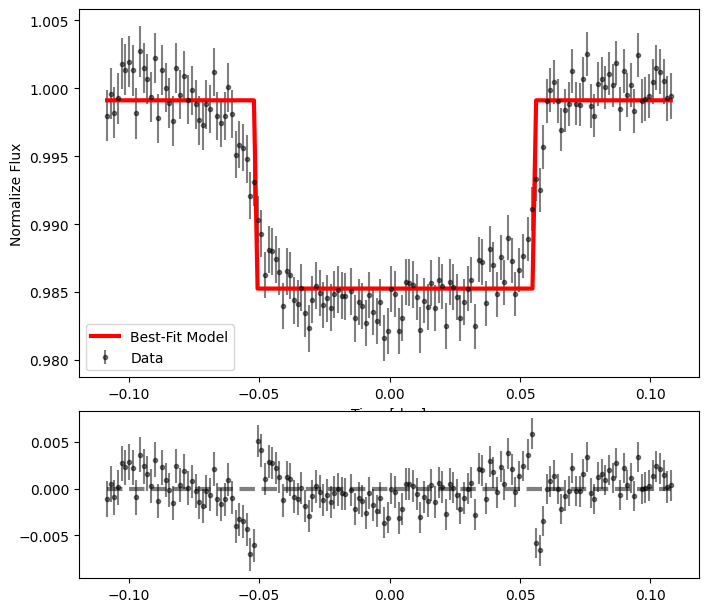

In [ ]:
# set up figure with various subplots.
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)
# plot best fit model over given data.
ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux = np.percentile(flat_samples, 50, axis=0)
model = box_model(time, center_time, duration, depth, delta_flux)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();
# add another plot for flux minus model.
ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [ ]:
# define a function to calculate reduced chi square value
def calculate_reduced_Chi2(flux, model, err, num_parameters):
  degree_freedom = len(flux) - num_parameters
  rChi2 = np.sum((flux - model)**2 / err**2) / degree_freedom
  return(rChi2)

In [ ]:
# calculate and print reduced chi square for box model
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 4))

Reduced Chi2 =  1.6071674089785764


In [ ]:
# define more complex model with trapezoidal features
def trapezoid_model(t, center_time, duration, depth, delta_flux, ingress):
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0 + ingress))
  f[ind] = 1.0 + delta_flux
  ind = np.where((np.abs(t - center_time) <= (duration / 2.0 + ingress)) & (np.abs(t - center_time) > (duration / 2.0)))
  for i in ind[0]:
    delta_t = np.abs(np.abs(t[i] - center_time) - (duration / 2.0))
    f[i] = depth / ingress * delta_t + 1.0 + delta_flux - depth
  return(f)

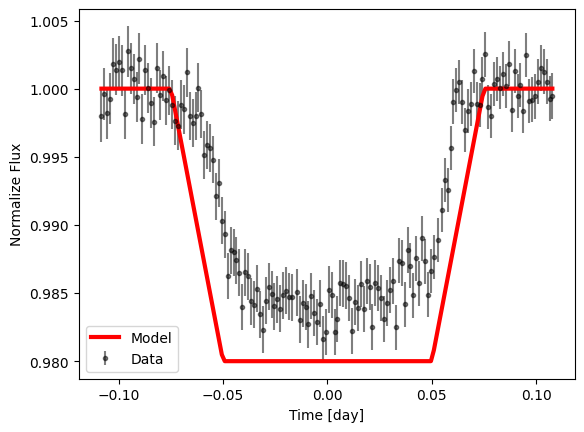

In [ ]:
# set initial parameters for new trapezoidal model.
center_time, duration, depth, delta_flux, ingress = 0.0, 0.1, 0.02, 0.0, 0.025

model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [ ]:
# define likelihood function for trapezoid model fitting
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux, ingress = theta
    model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
# define log prior for trapezoidal model fitting
def log_prior(theta):
    center_time, duration, depth, delta_flux, ingress = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 \
      and -0.1 < delta_flux < 0.1 and 0.0 < ingress < 0.1:
        return 0.0
    return -np.inf
# use other two to define log probability for trapezoid model.
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Reproduce code up to here for assignment for week 15

In [ ]:
import emcee

pos = np.array([0.0, 0.1, 0.02, 0.0, 0.025]) + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(time, flux, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [01:40<00:00, 49.90it/s]


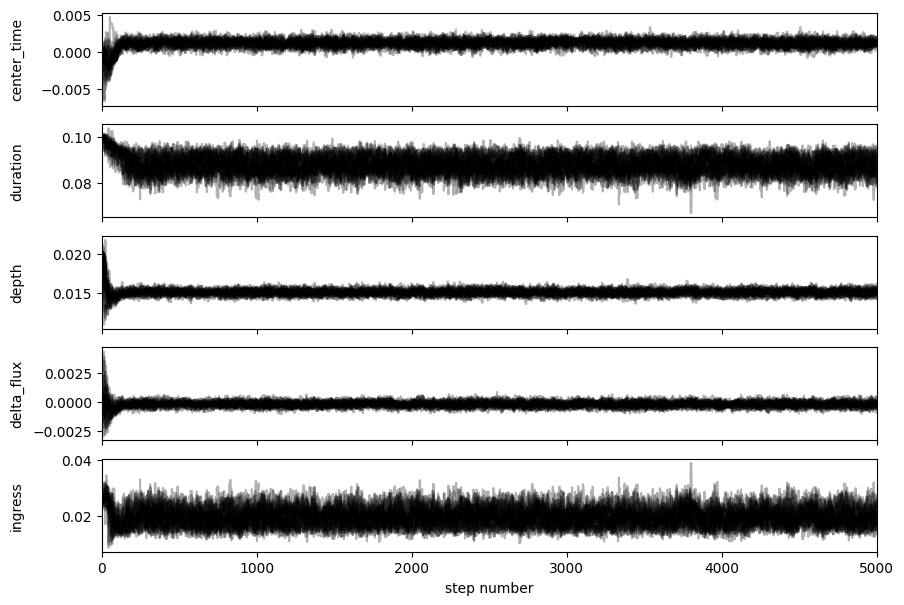

In [ ]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["center_time", "duration", "depth", "delta_flux", "ingress"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(3136, 5)


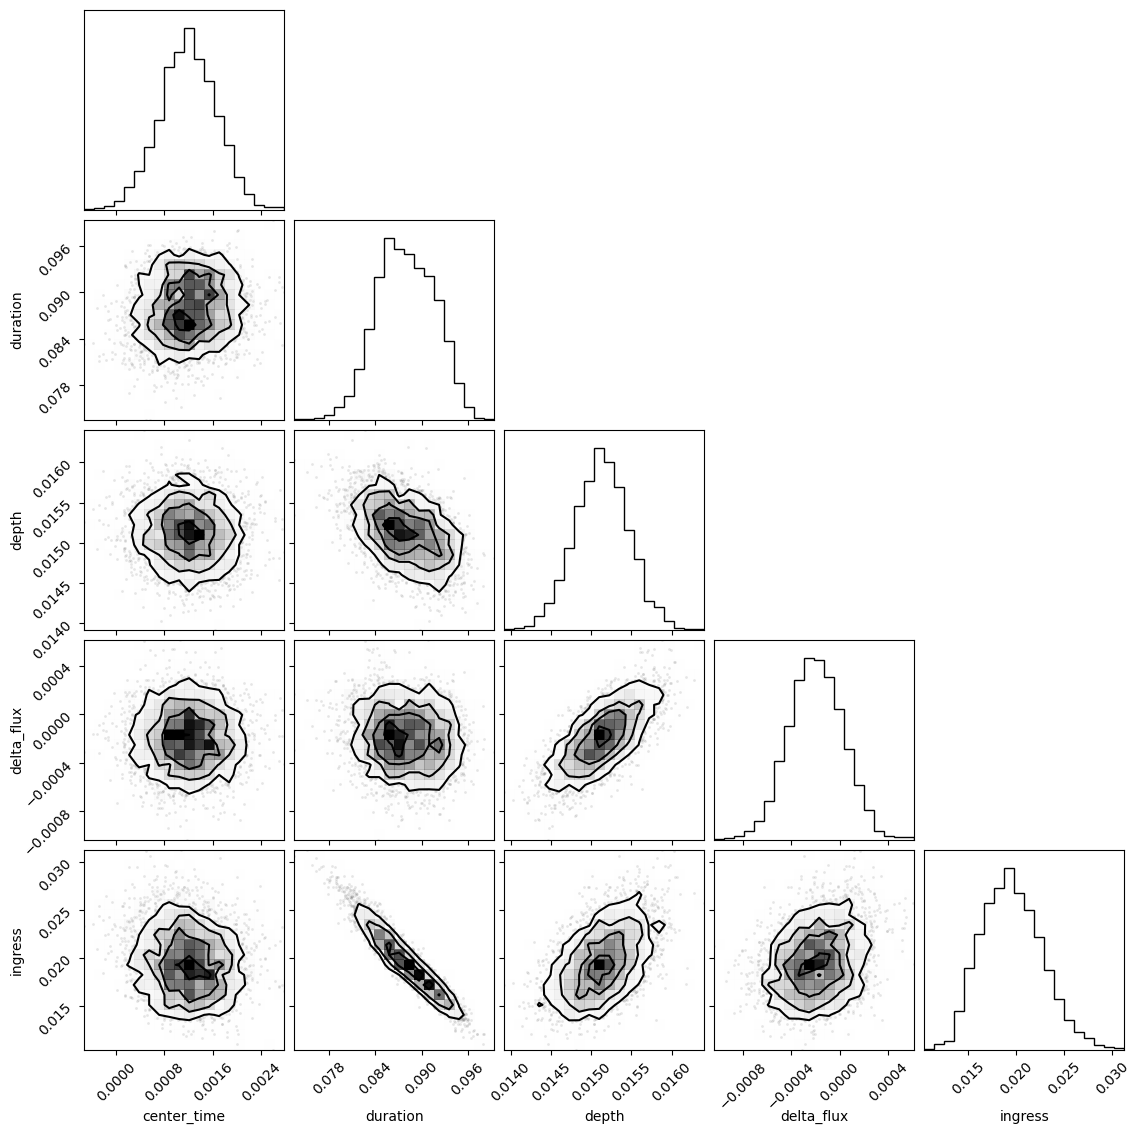

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=50, flat=True)
print(flat_samples.shape)

import corner
fig = corner.corner(flat_samples, labels=labels);

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

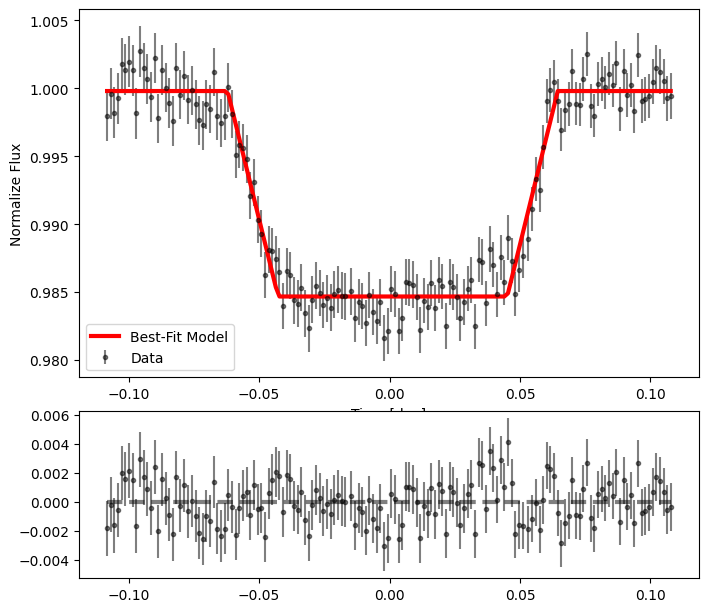

In [ ]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(4, 1)

ax = fig.add_subplot(gs[1:3])
center_time, duration, depth, delta_flux, ingress = np.percentile(flat_samples, 50, axis=0)
model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Best-Fit Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

ax = fig.add_subplot(gs[-1])
plt.errorbar(time, flux - model, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5)
plt.hlines(0, np.min(time), np.max(time), linestyle="dashed", linewidth=3.0, color="black", alpha=0.5)

In [ ]:
print("Reduced Chi2 = ", calculate_reduced_Chi2(flux, model, err, 5))

Reduced Chi2 =  0.7957051075046927
